# MemeQuest: От Парсинга до Проникновения в Эпицентр Интернет-Юмора и проверки гипотез

# 1. Как выглядит хранилище мемов

## 1.1. Что мы хотим получить

В данном проекте мы создадим инструмент, который автоматизирует сбор данных с веб-сайта [knowyourmeme.com:](http://knowyourmeme.com)

Цель — извлечь информацию о мемах, включая название, год создания, количество просмотров и текстовое описание. Эти данные в будущем могут быть использованы для анализа и прогнозирования тенденций популярности мемов.

## 1.2. Первые запросы



In [ ]:
import requests      # Библиотека для отправки запросов
import numpy as np   # Библиотека для матриц, векторов и линала
import pandas as pd  # Библиотека для табличек
import time          # Библиотека для времени

 Сохраним основную сслылку в переменную `page_link` адрес основной страницы и откроем её при помощи библиотеки `requests`.

 Иногда при попытке заполучить доступ к серверу вылезает 403-я ошибка, если он доступен и способен обрабатывать запросы, но по некоторым личным причинам отказывается это делать. Для этого воспользуемся fake-useragent. При вызове метода из различных кусочков будет генерироваться случайное сочетание операционной системы, спецификаций и версии браузера, которые можно передавать в запрос.

In [ ]:
page_link = 'http://knowyourmeme.com/memes/all/page/1'

In [ ]:
!pip install fake_useragent

In [ ]:
from fake_useragent import UserAgent

In [ ]:
UserAgent().chrome

'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36'

In [ ]:
response = requests.get(page_link, headers={'User-Agent': UserAgent().chrome})
response

<Response [200]>

Cоединение установлено и данные получены.

In [ ]:
html = response.content
html[:1000]

b"<!DOCTYPE html>\n<html xmlns:fb='https://www.facebook.com/2008/fbml' xmlns='https://www.w3.org/1999/xhtml'>\n<head>\n<meta content='width=1060' name='viewport'>\n<meta content='text/html; charset=utf-8' http-equiv='Content-Type'>\n\n<meta property='og:title' content='All Entries' />\n<meta property='og:site_name' content='Know Your Meme' />\n<meta property='og:image' content='https://a.kym-cdn.com/assets/kym-logo-large-2be3f3818691470a0369e154647ca0f0.png' />\n<meta property='og:type' content='article' />\n<meta property='fb:app_id' content='104675392961482' />\n<meta property='fb:pages' content='88519108736' />\n<meta property='article:publisher' content='https://www.facebook.com/knowyourmeme' />\n<meta name='twitter:card' content='summary_large_image' />\n<meta name='twitter:site' content='@knowyourmeme' />\n<meta name='twitter:creator' content='@knowyourmeme' />\n<meta name='twitter:title' content='All Entries' />\n<meta name='twitter:description' content='Know Your Meme | Our con

## 1.3. Beautiful Soup


Будем пользоваться пакетом **[bs4 , a.k.a BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/)** — библиотекой, которой преобразует сырой HTML-код веб-страницы в организованную структуру данных. Это облегчает поиск и извлечение нужных элементов, таких как теги, классы, атрибуты и тексты, для дальнейшей работы с контентом веб-страниц.

In [ ]:
from bs4 import BeautifulSoup

Передадим функции `BeautifulSoup` текст веб-страницы, которую мы скачали выше.

In [ ]:
soup = BeautifulSoup(html,'html.parser')

Теперь мы можем свободно перемещаться по HTML-дереву страницы и искать нужные нам теги.

In [ ]:
soup.html.head.title

<title>All Entries | Know Your Meme</title>

# 2. Собираем ссылки

После того, как мы успешно загрузили все ссылки с текущей страницы, нам необходимо перейти на следующую страницу и начать скачивание ссылок оттуда.

Обычно, все параметры, которые мы устанавливаем на сайте для поиска, отражаются на структуре ссылки. Если мы хотим получить первую страницу с мемами, мы должны будем обратиться к сайту по ссылке

                `http://knowyourmeme.com/memes/all/page/1`


Если мы захотим получить вторую страницу, нам придётся заменить номер страницы на 2


                `http://knowyourmeme.com/memes/all/page/2`

Таким образом мы сможем пройтись по всем страницам.

In [ ]:
import requests
from bs4 import BeautifulSoup
from fake_useragent import UserAgent

def getPageLinks(page_number):
    """
    Возвращает список ссылок на мемы, полученный с текущей страницы

    page_number: int/string
        номер страницы для парсинга

    """
    # составляем ссылку на страницу поиска
    page_link = 'https://knowyourmeme.com/memes/all/page/{}'.format(page_number)

    # запрашиваем данные по ней
    response = requests.get(page_link, headers={'User-Agent': UserAgent().chrome})

    if not response.ok:
        # если сервер нам отказал, вернем пустой список для текущей страницы
        return []

    # получаем содержимое страницы
    html = response.content
    soup = BeautifulSoup(html, 'html.parser')

    # ищем ссылки на мемы
    meme_links = soup.findAll(lambda tag: tag.name == 'a' and tag.get('class') == ['photo'])
    meme_links = [link.attrs['href'] for link in meme_links]

    return meme_links


In [ ]:
meme_links = getPageLinks(2)
meme_links[:2]

['https://knowyourmeme.com/memes/events/destinys-wife-runs-off',
 'https://knowyourmeme.com/memes/the-bloop']

Функция работает! :)

# 3. Скачиваем информацию об одном меме


In [ ]:
meme_page = 'http://knowyourmeme.com/memes/doge'

response = requests.get(meme_page, headers={'User-Agent': UserAgent().chrome})

html = response.content
soup = BeautifulSoup(html,'html.parser')

Напишем функцию для сбора этой статистики просмотров, комментариев, а также числа загруженных видео и фото, связанных с нашим мемом. Всё это хранится справа вверху под тэгами `"dd"` и с классами  `"views"`, `"videos"`, `"photos"` и `"comments"`

In [ ]:
def getStats(soup, stats):
    try:
        obj = soup.find('dd', attrs={'class':stats})
        obj = obj.find('a').text
        obj = int(obj.replace(',', ''))
    except:
        obj=None

    return obj

In [ ]:
views = getStats(soup, stats='views')
videos = getStats(soup, stats='videos')
photos = getStats(soup, stats='photos')
comments = getStats(soup, stats='comments')

print("Просмотры: {}\nВидео: {}\nФото: {}\nКомментарии: {}".format(views, videos, photos, comments))

Просмотры: 14107552
Видео: 105
Фото: 1795
Комментарии: 923


Достанем также дату и время добавления мема.

In [ ]:
date = soup.find('abbr', attrs={'class':'timeago'}).attrs['title']
date

'2023-11-01T14:25:11-04:00'

По аналогии можно извлечь всю остальную информацию со страницы.

In [ ]:
def getProperties(soup):

    meme_name = soup.find('section', attrs={'class':'info'}).find('h1').text.strip()

    properties = soup.find('aside', attrs={'class':'left'})


    meme_status = properties.find("dd")


    meme_status = "" if not meme_status else meme_status.text.strip()

    meme_type = properties.find('a', attrs={'class':'entry-type-link'})
    meme_type = "" if not meme_type else meme_type.text

    meme_origin_year = properties.find(text='\nYear\n')
    meme_origin_year = "" if not meme_origin_year else meme_origin_year.parent.find_next()
    meme_origin_year = meme_origin_year.text.strip()

    meme_origin_place = properties.find('dd', attrs={'class':'entry_origin_link'})
    meme_origin_place = "" if not meme_origin_place else meme_origin_place.text.strip()

    meme_tags = properties.find('dl', attrs={'id':'entry_tags'}).find('dd')
    meme_tags = "" if not meme_tags else meme_tags.text.strip()

    return meme_name, meme_status, meme_type, meme_origin_year, meme_origin_place, meme_tags

Свойства мема собрали. Теперь собираем по аналогии его текстовое описание.

In [ ]:
def getText(soup):

    body = soup.find('section', attrs={'class':'bodycopy'})

    meme_about = body.find('p')
    meme_about = "" if not meme_about else meme_about.text

    meme_origin = body.find(text='Origin') or body.find(text='History')
    meme_origin = "" if not meme_origin else meme_origin.parent.find_next().text

    if body.text:
        other_text = body.text.strip().split('\n')[4:]
        other_text = " ".join(other_text).strip()
    else:
        other_text = ""

    return meme_about, meme_origin, other_text

Наконец, создадим функцию, возвращающую всю информацию по текущему мему

In [ ]:
def getMemeData(meme_page):

    response = requests.get(meme_page, headers={'User-Agent': UserAgent().chrome})

    if not response.ok:
        return response.status_code

    html = response.content
    soup = BeautifulSoup(html,'html.parser')

    views = getStats(soup=soup, stats='views')
    videos = getStats(soup=soup, stats='videos')
    photos = getStats(soup=soup, stats='photos')
    comments = getStats(soup=soup, stats='comments')

    date = soup.find('abbr', attrs={'class':'timeago'}).attrs['title']

    meme_name, meme_status, meme_type, meme_origin_year, meme_origin_place, meme_tags =\
    getProperties(soup=soup)

    meme_about, meme_origin, other_text = getText(soup=soup)

    data_row = {"name":meme_name, "status":meme_status,
                "type":meme_type, "origin_year":meme_origin_year,
                "origin_place":meme_origin_place,
                "date_added":date, "views":views,
                "videos":videos, "photos":photos, "comments":comments, "tags":meme_tags,
                "about":meme_about, "origin":meme_origin, "other_text":other_text}

    return data_row

# 4. Итоговый цикл

Подготовим финальную табличку, чтобы в неё записывать все данные и напишем итоговый цикл. На всякий случай обернём его в `try-except`.

In [ ]:
from tqdm import tqdm_notebook

final_df = pd.DataFrame(columns=['name', 'status', 'type', 'origin_year', 'origin_place',
                                 'date_added', 'views', 'videos', 'photos', 'comments',
                                 'tags', 'about', 'origin', 'other_text'])

for page_number in tqdm_notebook(range(50), desc='Pages'):

    # собрали ссылки с текущей страницы
    meme_links = getPageLinks(page_number)

    for meme_link in tqdm_notebook(meme_links, desc='Memes', leave=False):

        # иногда с первого раза страничка не прогружается
        for i in range(5):
            try:
                # пытаемся собрать данные
                data_row = getMemeData(meme_link)
                final_df = final_df.append(data_row, ignore_index=True)
                # если всё получилось - выходим из внутреннего цикла
                break
            except:
                # Иначе, пробуем еще несколько раз, пока не закончатся попытки
                print('AHTUNG! parsing once again:', meme_link)
                continue

<ipython-input-21-cba4675f3ea5>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for page_number in tqdm_notebook(range(50), desc='Pages'):


Pages:   0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-21-cba4675f3ea5>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for meme_link in tqdm_notebook(meme_links, desc='Memes', leave=False):


Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

Memes:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find(text='History')
<ipython-input-21-cba4675f3ea5>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(data_row, ignore_index=True)
<ipython-input-18-ef463248e26b>:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin_year = properties.find(text='\nYear\n')
<ipython-input-19-c1f3c3a83542>:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  meme_origin = body.find(text='Origin') or body.find

In [ ]:
final_df.head()

,name,status,type,origin_year,origin_place,date_added,views,videos,photos,comments,tags,about,origin,other_text
0,Nudify / Undress AI,Submission,AI-generated,2023,Reddit,2023-12-09T06:00:00-05:00,57,0,5,0,"undress ai, nudify ai, deepfake, deepnude, non...",Nudify / Undress AI refers to AI programs that...,,Evidence of AI apps promoting non-consensual p...
1,Shut Up My Dad Works For X And Can X,Submission,Catchphrase,2018,Amino Apps,2023-12-08T20:17:45-05:00,113,0,17,1,shut up my dad works at,Shut Up! My Dad Works At X is an Exploitable p...,"On April 15th, 2018, the first usage of the me...","On April 15th, 2018, the first usage of the me..."
2,KSI vs. IShowSpeed Boxing Match,Submission,Competition,2023,YouTube,2023-12-08T17:52:54-05:00,71,0,0,1,"ksi, ishowspeed, boxing, youtube",KSI vs. IShowSpeed refers to the December 15th...,,"Following his loss to Fury on October 14th, th..."
3,Sky Bri,Submission,Actor,1999,"Pennsylvania, United States",2023-12-08T18:32:20-05:00,463,7,2,0,"who is sky bri, sky bri streamer, therealskybr...",Sky Bri or Skylar Bri also known as Realskybri...,,"On September 20th, 2021, the No Jumper podcast..."
4,Clem (Twitch Slang),Submission,Participatory Media,2023,Twitch,2023-12-08T16:54:42-05:00,442,0,5,1,"clem twitch slang meaning, clem, clem slang, s...",Clem (Twitch Slang) is a reference to the Warf...,"On December 7th, 2023, the 2023 Game Awards st...","On December 7th, 2023, the 2023 Game Awards st..."


In [ ]:

final_df.to_csv('wise.tsv', sep='\t', index=None)

# 5. Проверка гипотез

## 5.1. Выполним тест Шапиро-Уилка для проверки нормальности распределения числовых столбцов

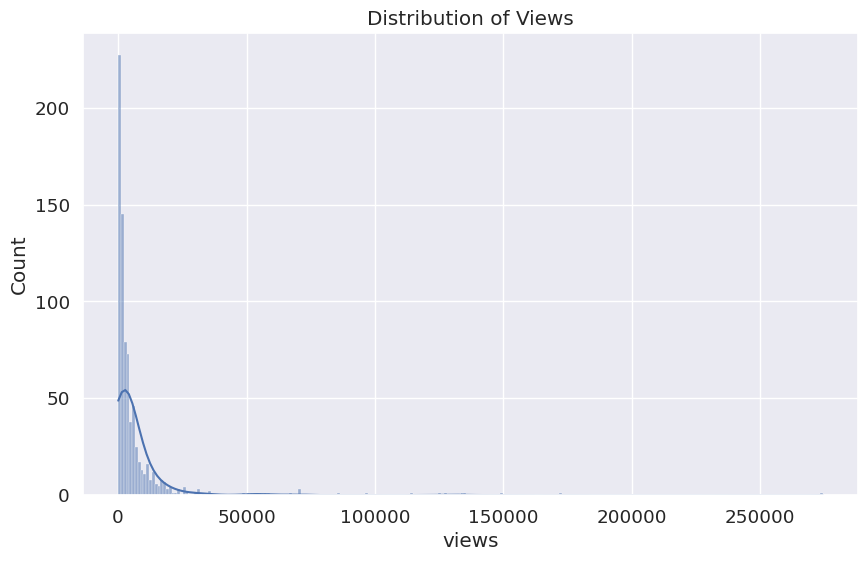

{'views': ShapiroResult(statistic=0.32586199045181274, pvalue=0.0),
 'videos': ShapiroResult(statistic=0.5740322470664978, pvalue=6.569917785063689e-40),
 'photos': ShapiroResult(statistic=0.3218387961387634, pvalue=0.0),
 'comments': ShapiroResult(statistic=0.18090885877609253, pvalue=0.0)}

In [ ]:
from scipy.stats import shapiro, mannwhitneyu, kruskal, ttest_ind
import numpy as np

data_new.describe(include='all')


shapiro_results = {col: shapiro(data_new[col]) for col in ['views', 'videos', 'photos', 'comments']}


plt.figure(figsize=(10, 6))
sns.histplot(data_new['views'], kde=True)
plt.title('Distribution of Views')
plt.show()


shapiro_results




Результаты теста Шапиро-Уилка для всех рассмотренных числовых переменных указывают на то, что данные не соответствуют нормальному распределению. Это означает, что для сравнения средних или медиан между различными группами в данных следует использовать непараметрические тесты, такие как Манна-Уитни или Краскела-Уоллиса, вместо параметрических тестов, таких как t-тест или ANOVA, которые предполагают нормальность распределения.

## 5.2. Проведем тест Краскела-Уоллиса

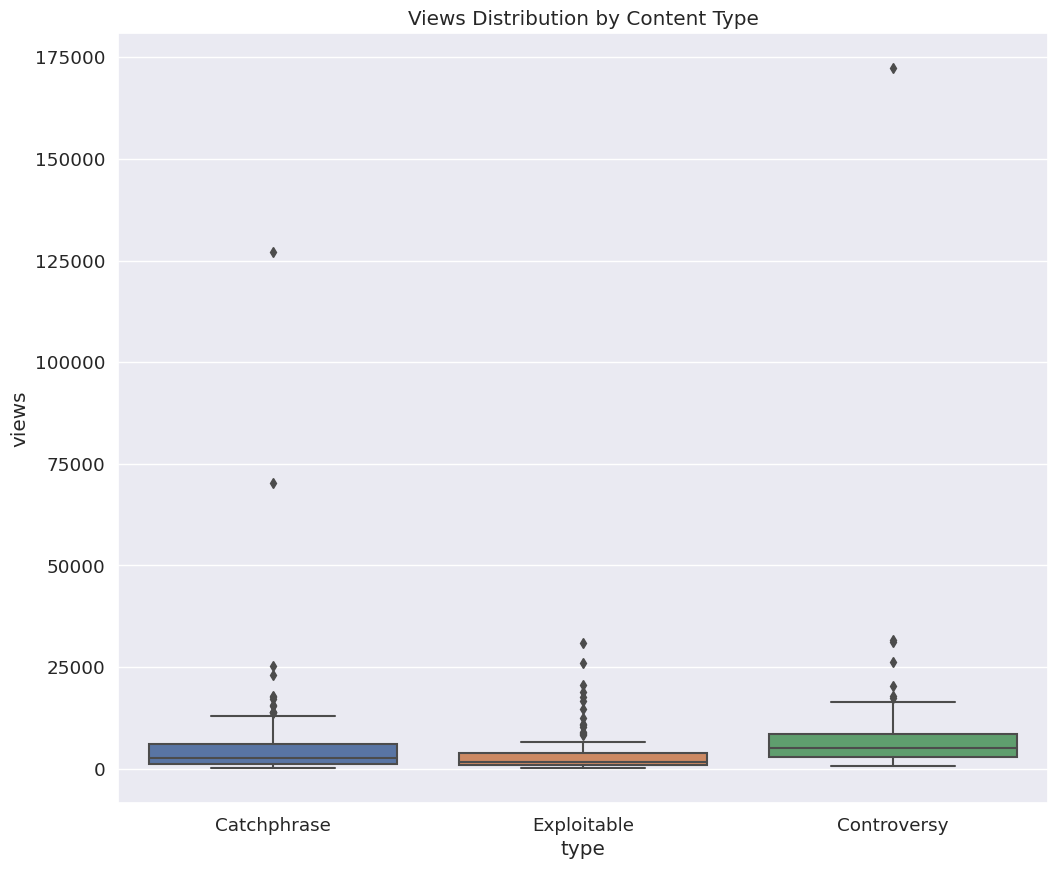

(KruskalResult(statistic=22.657740267102735, pvalue=1.2020823341773459e-05),
 ['Catchphrase', 'Exploitable', 'Controversy'])

In [ ]:
type_counts = data_new['type'].value_counts()

top_types = type_counts.head(3).index.tolist()

views_by_type = [data_new.loc[data_new['type'] == typ, 'views'] for typ in top_types]

kruskal_test_result = kruskal(*views_by_type)

plt.figure(figsize=(12, 6))
sns.boxplot(x='type', y='views', data=data_new[data_new['type'].isin(top_types)])
plt.title('Views Distribution by Content Type')
plt.show()

kruskal_test_result, top_types



Так как p-значение меньше 0.05, мы отвергаем нулевую гипотезу теста Краскела-Уоллиса, что указывает на статистически значимые различия в количестве просмотров между выбранными типами контента.

Визуализация с помощью ящичка с усами показывает распределение просмотров для каждого из этих трех типов. Это дает нам представление о медиане, межквартильном размахе и наличии выбросов в данных.

На основе этих результатов можно провести дополнительный анализ, например, используя парные непараметрические тесты, такие как Манна-Уитни, чтобы определить, между какими конкретными группами существуют различия



## 5.3 Проведем тест Манна-Уитни

In [ ]:
if clean_data['views'].dtype != np.float64:
    clean_data['views'] = pd.to_numeric(clean_data['views'], errors='coerce')

clean_data = clean_data.dropna(subset=['views'])

mannwhitney_results = {}
for i in range(len(top_types)):
    for j in range(i+1, len(top_types)):
        type1 = top_types[i]
        type2 = top_types[j]
        stat, p = mannwhitneyu(clean_data[clean_data['type'] == type1]['views'],
                                clean_data[clean_data['type'] == type2]['views'])
        mannwhitney_results[(type1, type2)] = (stat, p)

mannwhitney_results





{('Catchphrase', 'Exploitable'): (6282.5, 0.10286548847946038),
 ('Catchphrase', 'Controversy'): (2577.5, 0.000540246329208109),
 ('Exploitable', 'Controversy'): (1703.0, 2.6784260198147933e-06)}

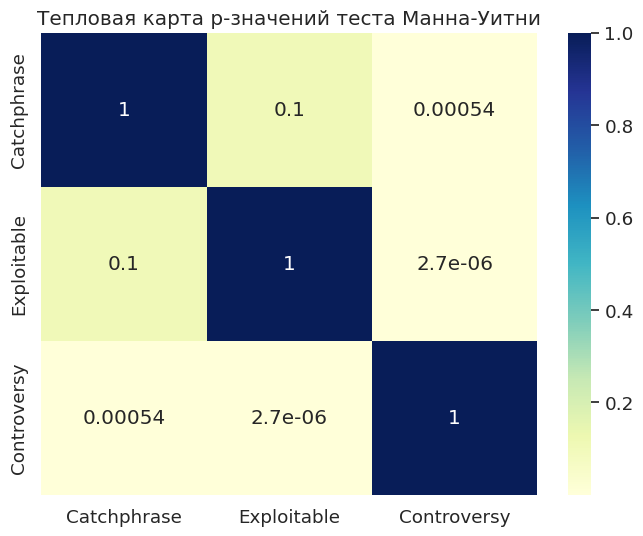

In [ ]:
{
    ('Catchphrase', 'Exploitable'): (6282.5, 0.10286548847946038),
    ('Catchphrase', 'Controversy'): (2577.5, 0.000540246329208109),
    ('Exploitable', 'Controversy'): (1703.0, 2.6784260198147933e-06)
}


media_types = list(set([pair for pairs in mann_whitney_results.keys() for pair in pairs]))



p_value_matrix = np.full((len(media_types), len(media_types)), np.nan)


for i, media_type1 in enumerate(media_types):
    for j, media_type2 in enumerate(media_types):
        if media_type1 == media_type2:
            p_value_matrix[i, j] = 1
        else:
            p_value = mann_whitney_results.get((media_type1, media_type2)) or mann_whitney_results.get((media_type2, media_type1))
            if p_value:
                p_value_matrix[i, j] = p_value[1]


plt.figure(figsize=(8, 6))
sns.heatmap(p_value_matrix, annot=True, xticklabels=media_types, yticklabels=media_types, cmap="YlGnBu", fmt=".2g")
plt.title('Тепловая карта p-значений теста Манна-Уитни')
plt.show()


На основе результатов теста Манна-Уитни U можно сделать вывод, что в представленном датасете существуют статистически значимые различия в количестве просмотров между некоторыми категориями контента. Конкретно, контент типа Controversy отличается по количеству просмотров от Catchphrase и Exploitable, причем такие различия статистически подтверждены. Между контентом типа Catchphrase и Exploitable статистически значимой разницы в количестве просмотров не обнаружено. Эти результаты подчеркивают важность типа контента в определении его популярности, измеряемой через просмотры.

## 5.4 Определить направление, посмотрев на медианные значения

In [ ]:
median_views = clean_data.groupby('type')['views'].median()[top_types]

median_views


Данные показывают, что контент типа Controversy в среднем привлекает больше просмотров по сравнению с типами Catchphrase и Exploitable. Таким образом, направление различий, обнаруженных в тестах Манна-Уитни U, заключается в том, что Controversy имеет более высокую медиану просмотров. Это может указывать на большую популярность или привлекательность такого типа контента среди аудитории.

**Вывод:** было выявлено, что среди различных типов контента в представленном наборе данных тип Controversy статистически значимо отличается по количеству просмотров от типов Catchphrase и Exploitable. Это указывает на большую популярность или привлекательность контента типа Controversy для аудитории. В то же время, различия в количестве просмотров между Catchphrase и Exploitable не были статистически значимыми, что свидетельствует о схожести этих типов контента с точки зрения привлечения внимания аудитории.